<a href="https://colab.research.google.com/github/gggauravgandhi/colab/blob/master/Deep_Layout_Parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Layout Parsing

In this tutorial, we will show how to use the `layoutparser` API to 

1. Load Deep Learning Layout Detection models and predict the layout of the paper image
2. Use the coordinate system to parse the output 

The `paper-image` is from https://arxiv.org/abs/2004.08686.

In [1]:
!pip3 install layoutparser

In [2]:
!pip3 install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-rpqlkgbu/detectron2_6ce0dbe66ed448a2a855d5ced0175ca1
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-rpqlkgbu/detectron2_6ce0dbe66ed448a2a855d5ced0175ca1
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached fvcore-0.1.3.post20210317.tar.gz (47 kB)
  Using cached omegaconf-2.1.0-py3-none-any.whl (74 kB)
  Using cached antlr4-python3-runtime-4.8.tar.gz (112 kB)
  Created wheel for detectron2: filename=detectron2-0.4-cp37-cp37m-linux_x86_64.whl size=5158125 sha256=18806edf93eae156ec852f6e7a9e8915f09e90a276be8b8b9c55d85bbde3455b
  Stored in directory: /tmp/pip-ephem-wheel-cache-bib_28w6/wheels/87/3f/26/dc45098d34763c9dc05ea3ab35c6dec6e9e8c16ac741efb741
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-py3-none-any.whl size=58543 sha256=82390a

In [3]:
import layoutparser as lp
import cv2

## Use Layout Models to detect complex layout 

`layoutparser` can identify the layout of the given document with only 4 lines of code.

In [35]:
image = cv2.imread("doc1.jpg")
image = image[..., ::-1] 
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

In [43]:
model = lp.Detectron2LayoutModel('lp://TableBank/faster_rcnn_R_101_FPN_3x/config',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8])
    # Load the deep layout model from the layoutparser API 
    # For all the supported model, please check the Model 
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

In [44]:
layout = model.detect(image)
    # Detect the layout of the input image

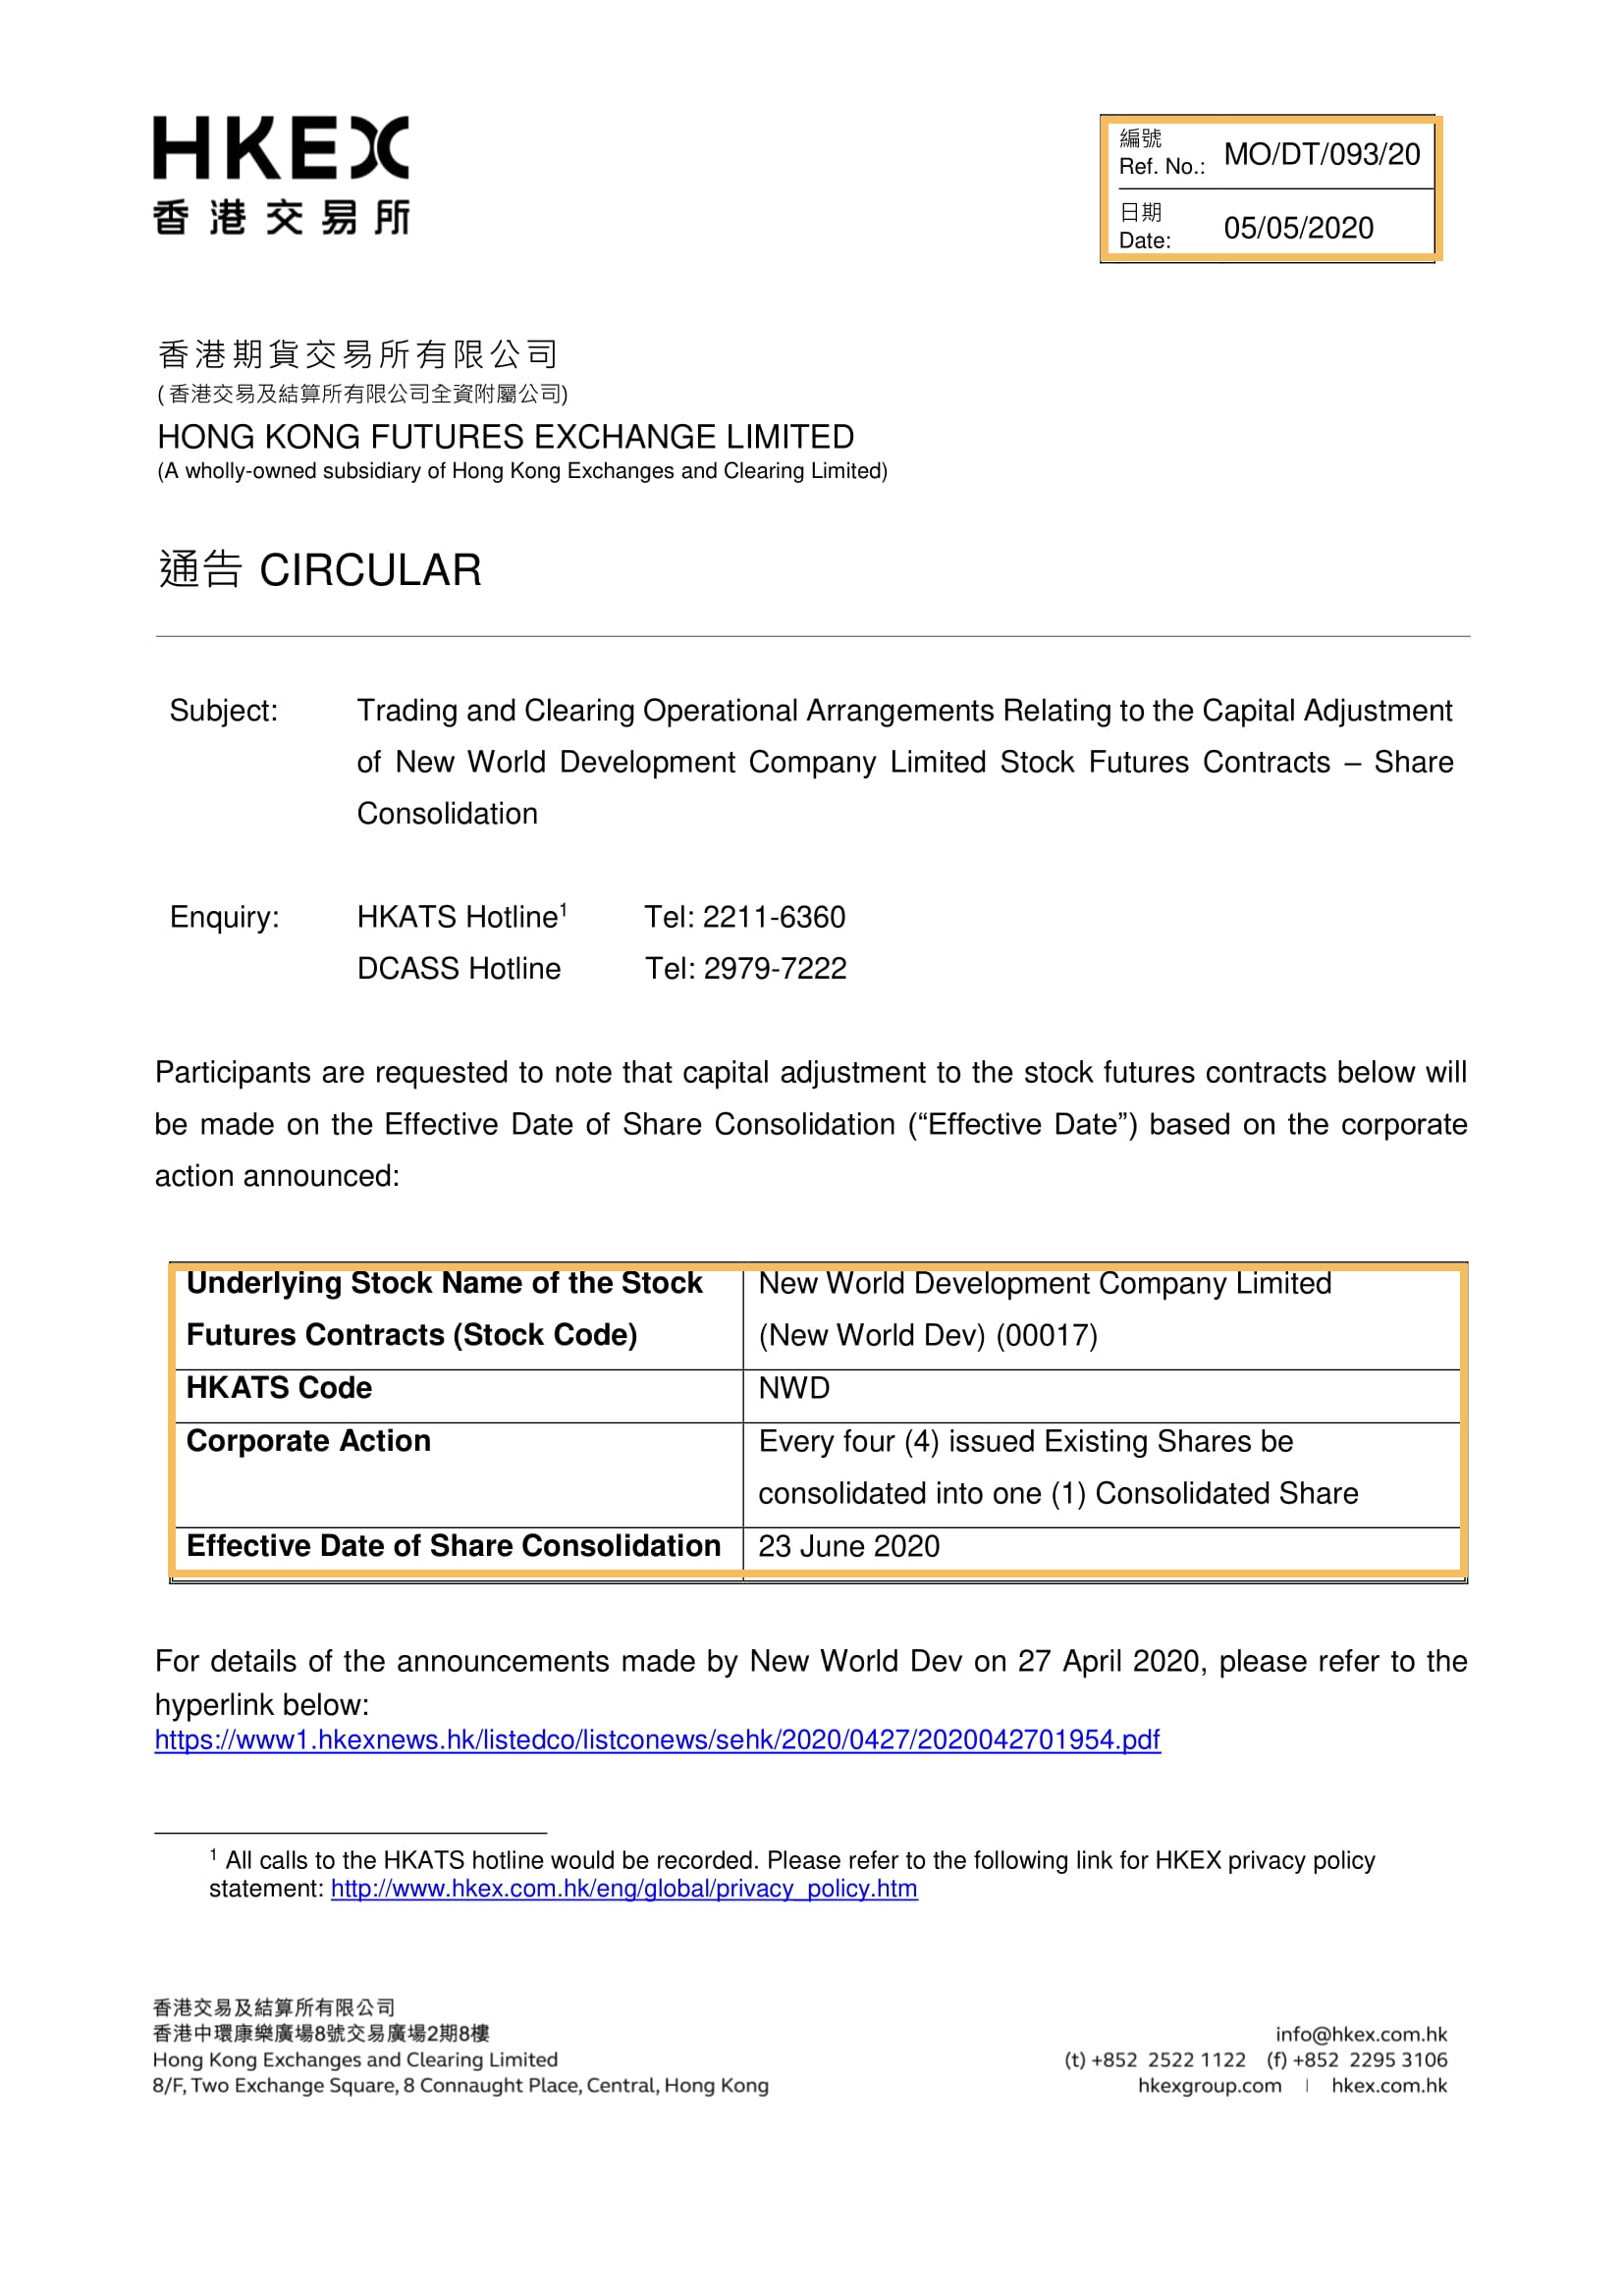

In [45]:
lp.draw_box(image, layout)
    # Show the detected layout of the input image

## Check the results from the model 

In [46]:
type(layout)         

layoutparser.elements.Layout

The `layout` variables is a `Layout` instance, which is inherited from list and supports handy methods for layout processing. 

In [47]:
layout[0]

TextBlock(block=Rectangle(x_1=171.3678436279297, y_1=1287.251220703125, x_2=1494.84716796875, y_2=1606.539794921875), text=None, id=None, type=Table, parent=None, next=None, score=0.9837785363197327)

`layout` contains a series of `TextBlock`s. They store the coordinates in the `.block` variable and other information of the blocks like block type in `.type`, text in `.text`, etc. More information can be found at the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/elements.html#layoutparser.elements.TextBlock). 

## Use the coordinate system to process the detected layout

Firstly we filter text region of specific type:

In [48]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

As there could be text region detected inside the figure region, we just drop them:

In [49]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

Finally sort the text regions and assign ids: 

In [50]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

Visualize the cleaned text blocks:

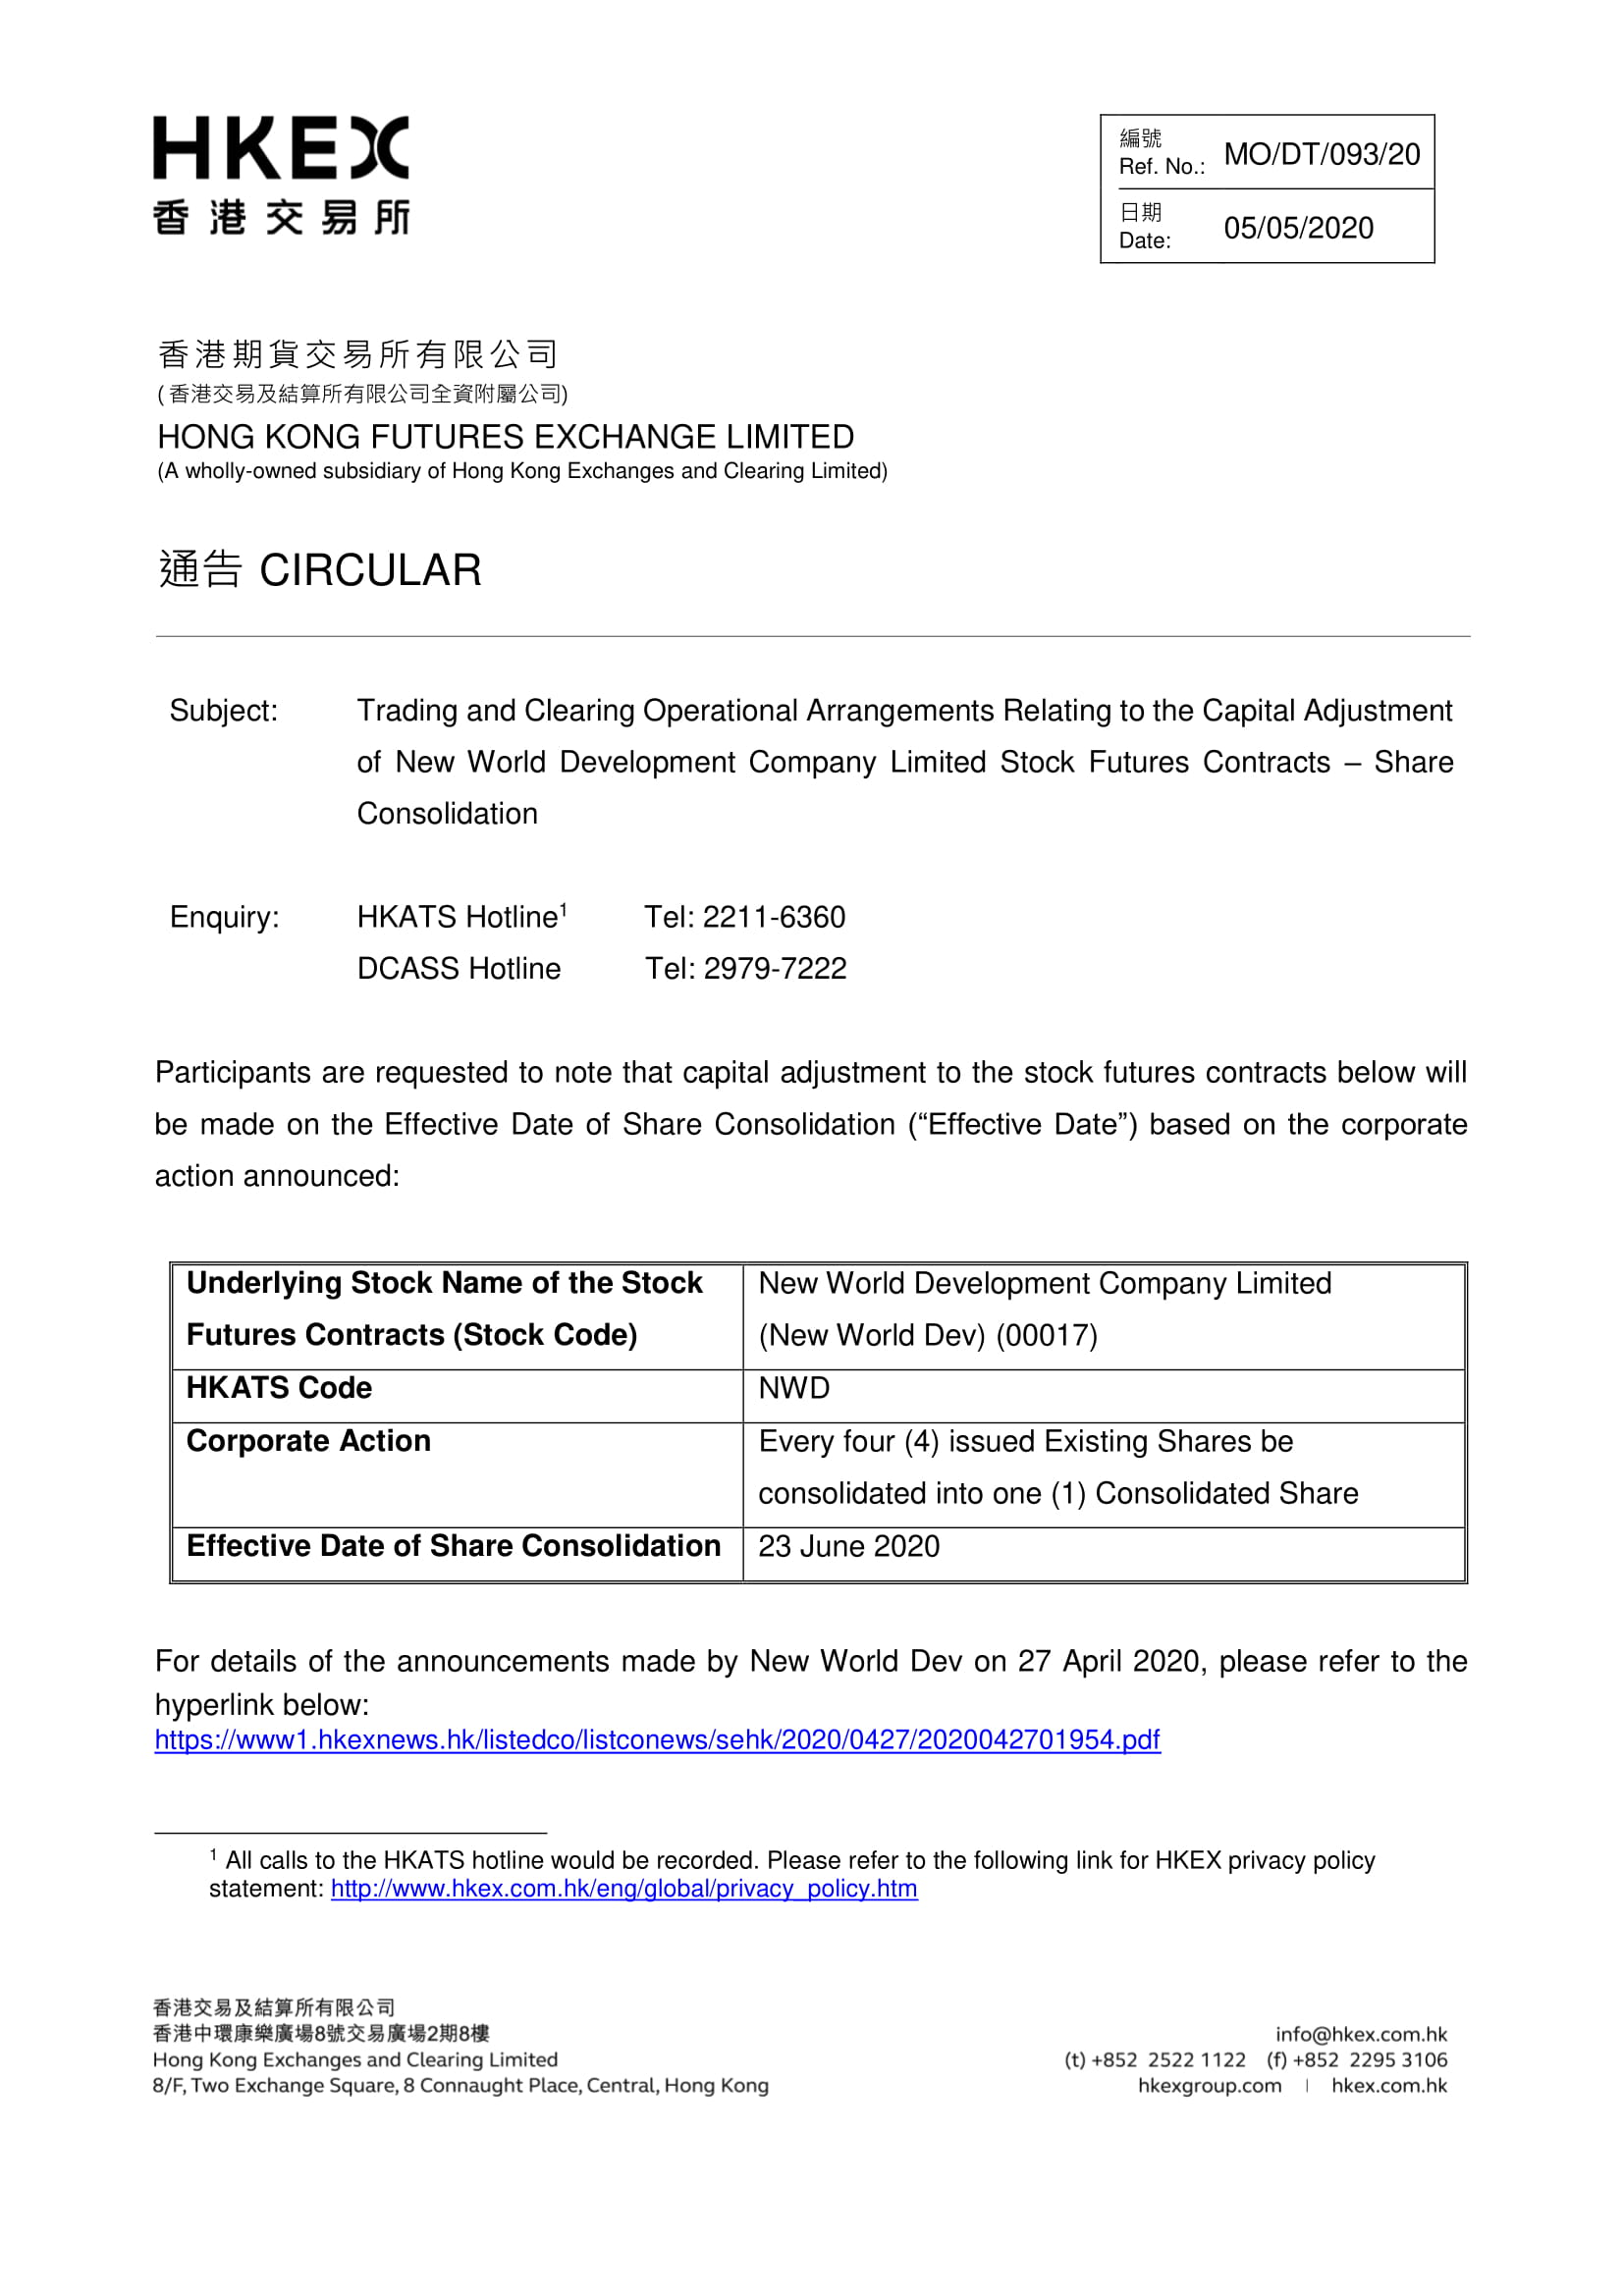

In [51]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

## Fetch the text inside each text region

We can also combine with the OCR functionality in `layoutparser` to fetch the text in the document. 

In [52]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

ModuleNotFoundError: ignored

In [53]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Figure 7: Annotation Examples in HJDataset. (a) and (b) show two examples for the labeling of main pages. The boxes
are colored differently to reflect the layout element categories. Illustrated in (c), the items in each index page row are
categorized as title blocks, and the annotations are denser.
---
tion over union (IOU) level [0.50:0.95]’, on the test data. In
general, the high mAP values indicate accurate detection of
the layout elements. The Faster R-CNN and Mask R-CNN
achieve comparable results, better than RetinaNet. Notice-
ably, the detections for small blocks like title are less pre-
cise, and the accuracy drops sharply for the title category. In
Figure 8, (a) and (b) illustrate the accurate prediction results
of the Faster R-CNN model.
---
We also examine how our dataset can help with
world document digitization application. When digitizing
new publications, researchers usually do not generate large
scale ground truth data to train their layout analysis models.
If they are 